# 1，数据集准备


数据集来自kaggle的dog vs cat主页（https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data）


In [6]:
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile
import os
import h5py

data_path = './'
train_dir_name = 'train'
test_dir_name = 'test'

## check if the train and  test data is exist
if not isdir(data_path + train_dir_name):
    if not isfile(data_path + train_dir_name + '.zip'):
        print ("Please download train.zip from kaggle!")
        assert(False)
    else:
        with zipfile.ZipFile(data_path + train_dir_name + '.zip') as azip:
            print ("Now to extract %s " % (data_path + train_dir_name + '.zip'))
            azip.extractall()
    
if not isdir(data_path + test_dir_name):
    if not isfile(data_path + test_dir_name + '.zip'):
        print ("Please download test1.zip from kaggle!")
        assert(False)
    else:
        with zipfile.ZipFile(data_path + test_dir_name + '.zip') as azip:
            print ("Now to extract %s " % (data_path + test_dir_name + '.zip'))
            azip.extractall()
print ("Data is ready!")

Data is ready!


# 2，将猫狗训练数据分开存放

首先我们会实施第一个方案，就是只用一个预训练模型来进行微调，看看这个模型做得怎么样？初步采用的模型是ResNet-50，所以我们就需要按照该模型的要求来对图片进行预处理。进一步地，为了尽快实现想法，我打算采用Keras平台，因为Keras已经包含了众多知名的模型，并且可以很轻易地加载与训练权重。而且Keras也提供了很方便的工具（image generator）来帮助我们直接从硬盘加载图片到模型，这样不但减少了代码量，而且利用Keras自带的程序能够极大减少内存的浪费（相比于手动一次性加载到内存）。但是image generator需要图片已经根据类别放入不同的文件夹。所以接下来的事情就是将训练和测试样本按照类别放入不同的文件夹。

In [7]:
train_dir = data_path + train_dir_name
test_dir = data_path + test_dir_name

## get all train filenames and test filenames
train_filenames = os.listdir(train_dir)
test_filenames = os.listdir(test_dir)

## get all dogs and cats
cat_names = filter(lambda x:x[:3] == 'cat', train_filenames)
dog_names = filter(lambda x:x[:3] == 'dog', train_filenames)

现在已经获得了文件名，现在需要另外建立一个文件夹，用于存储分开的猫狗图片。为了节省空间，这里采用建立软链接的方式来分开存储猫狗图片。

In [8]:
## check if we did that
test_link_path = './test_link'
test_link_data = './test_link/data'

train_link_path = './train_link'
train_link_cat = './train_link/cat'
train_link_dog = './train_link/dog'

if not isdir(test_link_path):
    print ("Now to build %s!" % (test_link_path))
    os.makedirs(test_link_path)
    os.symlink('../' + test_dir_name, test_link_data)
    
if not isdir(train_link_path):
    print ("Now to build %s!" % (train_link_path))
    os.makedirs(train_link_cat)
    os.makedirs(train_link_dog)
    ## create link for the image
    for file in cat_names:
        os.symlink('../../' + train_dir_name+'/'+file, train_link_cat+'/'+file)
    for file in dog_names:
        os.symlink('../../' + train_dir_name+'/'+file, train_link_dog+'/'+file)

print ("Build all linkage complete!")

Build all linkage complete!


# 3, 载入ResNet-50模型，提取中间值

现在我们需要载入预训练的ResNet-50模型，并且，由于ResNet-50模型的输出是1000维的向量，而我们的功能是二分类，所以只需要输出单一的概率即可，所以需要替换掉原始的输出层换成我们的sigmoid激活函数。


In [4]:
from keras.applications.resnet50 import ResNet50

## resNet-50 do not need preprocessing, so the resNet_input_shape is not neccessary
resNet_input_shape = (224,224,3)

res_x = Input(shape=resNet_input_shape)
res_x = Lambda(keras.applications.resnet50.preprocess_input)(res_x)
res_model = ResNet50(include_top=False, weights='imagenet', input_tensor=res_x, input_shape=resNet_input_shape)

print (res_model.output)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Tensor("avg_pool/AvgPool:0", shape=(?, 1, 1, 2048), dtype=float32)


由于我们采用的预训练模型，暂时只是在ResNet-50上微调，不会对全连接层以外的其它层进行训练。所以如果每次都从上面的模型的输入端进行输入的话会产生很多重复的计算，显得不那么高效。那么这里有一个技巧，可以先把全连接层以前的中间值（以下均称为向量）预先计算并保存起来，由于只需要训练之后的全连接层，所以，将这些保存的向量作为样本，当做后面的全连接层的训练的输入就好了。

In [5]:
vec_dir_name = "vect/"
resnet_50_vec_name = 'resnet-50.h5'
vec_dir_path = data_path + "vect"
resnet_50_vec_path = data_path + vec_dir_name + resnet_50_vec_name
print (vec_dir_path)
if not isdir(vec_dir_path):
    os.makedirs(vec_dir_path)
    print ("Make vector dir:%s" % (vec_dir_path))
    
"""
check if the resnet-50 vector file is exist
"""
if not isfile(resnet_50_vec_path):
    with h5py.File(resnet_50_vec_path, 'w') as f:
        print ("creating vector!!")
        out = GlobalAveragePooling2D()(res_model.output)
        res_vec_model = Model(inputs=res_model.input, outputs=out)
        
        ## save vector
        gen = ImageDataGenerator()
        test_gen = ImageDataGenerator()
        """
        classes = ['cat', 'dog'] -- cat is 0, dog is 1, so we need write this
        class_mode = None -- i will not use like 'fit_fitgenerator', so i do not need labels
        shuffle = False -- it is unneccssary
        batch_size = 64 
        """
        image_size = (224,224)
        train_generator = gen.flow_from_directory(train_link_path, image_size, color_mode='rgb', \
                                                  classes=['cat', 'dog'], class_mode=None, shuffle=False, batch_size=64)
        test_generator = test_gen.flow_from_directory(test_link_path, image_size, color_mode='rgb', \
                                                  class_mode=None, shuffle=False, batch_size=64)        
        """
        steps = None, by default, the steps = len(generator)
        """
        vector = res_vec_model.predict_generator(train_generator)
        test_vector = res_vec_model.predict_generator(test_generator)
        
        f.create_dataset('x_train', data=vector)
        f.create_dataset("y_train", data=train_generator.classes)
        f.create_dataset("test", data=test_vector)


./vect


# 4, 训练一个模型

In [13]:
import numpy as np
from sklearn.utils import shuffle


with h5py.File(resnet_50_vec_path, 'r') as f:
    x_train = np.array(f['x_train'])
    y_train = np.array(f['y_train'])
    x_train, y_train = shuffle(x_train, y_train, random_state=0)
    
input_tensor = Input(shape=(2048,))
x = Dropout(0.4)(input_tensor)
x = Dense(1, activation='sigmoid', name='res_dense_1')(x)

model = Model(inputs=input_tensor, outputs=x)

model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

hist = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 3s 136us/step - loss: 0.0781 - acc: 0.9729 - val_loss: 0.0398 - val_acc: 0.9850
Epoch 2/50
20000/20000 [==============================] - 2s 104us/step - loss: 0.0416 - acc: 0.9845 - val_loss: 0.0315 - val_acc: 0.9880
Epoch 3/50
20000/20000 [==============================] - 2s 104us/step - loss: 0.0361 - acc: 0.9877 - val_loss: 0.0322 - val_acc: 0.9880
Epoch 4/50
20000/20000 [==============================] - 2s 104us/step - loss: 0.0340 - acc: 0.9883 - val_loss: 0.0309 - val_acc: 0.9890
Epoch 5/50
20000/20000 [==============================] - 2s 104us/step - loss: 0.0342 - acc: 0.9879 - val_loss: 0.0307 - val_acc: 0.9882
Epoch 6/50
20000/20000 [==============================] - 2s 104us/step - loss: 0.0339 - acc: 0.9888 - val_loss: 0.0292 - val_acc: 0.9898
Epoch 7/50
20000/20000 [==============================] - 2s 104us/step - loss: 0.0305 - acc: 0.9886 - val_loss: 0.0307 - v

上面的结果看起来还不错，本来是0.035这样的验证集（不是测试集）loss可以在leaderboard上排名前10名了，待会儿再在测试集上得出结果提交到kaggle。其实在得到这个结果之前犯了一个错误，就是从文件中读取出来x_train和y_train之后，没有对样本进行shuffle。导致验证集的loss在0.2到0.7不断地跳动，我刚开始还以为只是模型的结构引起的过拟合，所以修改了dropout的rate，将其变大，也就是丢弃的几率变大。而且还在输出层对参数加了一个L2的正则化。但是几乎没有效果。所以我就意识到，可能不是模型的问题。然后在群上看他们聊天聊到shuffle，我恍然大悟，原来是我读出来的时候没有进行shuffle，现在就好了。

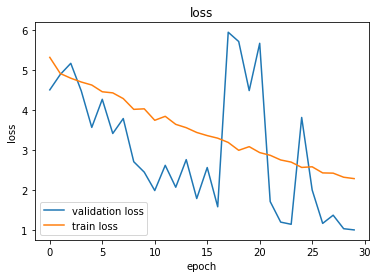

In [25]:
import matplotlib.pyplot as plt

def show_loss(hist, title='loss'):
    # show the training and validation loss
    plt.plot(hist.history['val_loss'], label="validation loss")
    plt.plot(hist.history['loss'], label="train loss")
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title(title)
    plt.legend()
    plt.show()
def show_acc(hist, title='accuracy'):
    # show the training and validation loss
    plt.plot(hist.history['val_acc'], label="validation accuracy")
    plt.plot(hist.history['acc'], label="train accuracy")
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title(title)
    plt.legend()
    plt.show()

show_loss(hist)

# 5, 预测测试集

In [15]:
import pandas as pd

def get_test_result(model, test_vec_path, image_size, model_name=""):
    with h5py.File(test_vec_path, 'r') as f:
        x_test = np.array(f['test'])

    pred_test = model.predict(x_test)
    pred_test = pred_test.clip(min=0.005, max=0.995)
    
    df = pd.read_csv("sampleSubmission.csv")

    gen = ImageDataGenerator()
    test_generator = gen.flow_from_directory(test_link_path, image_size, color_mode='rgb',
                                             shuffle=False, batch_size=64, class_mode=None)

    for i, fname in enumerate(test_generator.filenames):
        index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
        #df.set_value(index-1, 'label', y_pred[i])
        df.loc[index-1, 'label'] = pred_test[i]
    
    df.to_csv('%s.csv' % (model_name), index=None)
    print ('test result file %s.csv generated!' % (model_name))
    df.head(10)

get_test_result(model, resnet_50_vec_path, (224, 224), model_name="resnet-50")

Found 12500 images belonging to 1 classes.
test result file resnet-50.csv generated!


# 6.改进模型

提交到kaggle之后，分数为0.05518，是leaderboard的前10%。但是现在的结果不是很理想，所以我打算在此基础上添加一个全连接层，然后进行训练，看看是否能够增强模型的能力，减小训练loss和验证loss。并且调试一下其他的学习算法，比如Adam。

In [35]:
input_tensor = Input(shape=(2048,))
x = Dropout(0.6)(input_tensor)
x = Dense(1024, activation='relu', name='res_dense_1')(x)
x = Dropout(0.6)(x)
x = Dense(1, activation='sigmoid', name='res_dense_2')(x)

model = Model(inputs=input_tensor, outputs=x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

hist = model.fit(x_train, y_train, batch_size=32, epochs=30, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 3s 171us/step - loss: 0.1365 - acc: 0.9633 - val_loss: 0.0367 - val_acc: 0.9884
Epoch 2/30
20000/20000 [==============================] - 3s 131us/step - loss: 0.0698 - acc: 0.9765 - val_loss: 0.0344 - val_acc: 0.9874
Epoch 3/30
20000/20000 [==============================] - 3s 130us/step - loss: 0.0620 - acc: 0.9782 - val_loss: 0.0335 - val_acc: 0.9894
Epoch 4/30
20000/20000 [==============================] - 3s 131us/step - loss: 0.0530 - acc: 0.9808 - val_loss: 0.0286 - val_acc: 0.9888
Epoch 5/30
20000/20000 [==============================] - 3s 131us/step - loss: 0.0495 - acc: 0.9813 - val_loss: 0.0286 - val_acc: 0.9900
Epoch 6/30
20000/20000 [==============================] - 3s 131us/step - loss: 0.0517 - acc: 0.9818 - val_loss: 0.0301 - val_acc: 0.9890
Epoch 7/30
20000/20000 [==============================] - 3s 130us/step - loss: 0.0514 - acc: 0.9828 - val_loss: 0.0317 - v

In [36]:
hist2 = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 3s 130us/step - loss: 0.0314 - acc: 0.9892 - val_loss: 0.0333 - val_acc: 0.9880
Epoch 2/5
20000/20000 [==============================] - 3s 130us/step - loss: 0.0327 - acc: 0.9882 - val_loss: 0.0337 - val_acc: 0.9882
Epoch 3/5
20000/20000 [==============================] - 3s 130us/step - loss: 0.0323 - acc: 0.9888 - val_loss: 0.0289 - val_acc: 0.9898
Epoch 4/5
20000/20000 [==============================] - 3s 129us/step - loss: 0.0332 - acc: 0.9885 - val_loss: 0.0325 - val_acc: 0.9880
Epoch 5/5
20000/20000 [==============================] - 3s 130us/step - loss: 0.0324 - acc: 0.9891 - val_loss: 0.0333 - val_acc: 0.9882


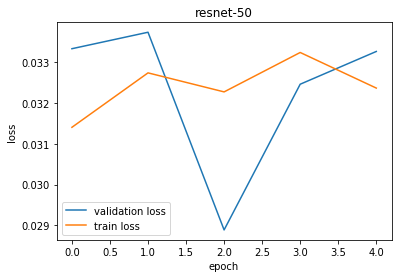

In [37]:
show_loss(hist2)

In [38]:
get_test_result(model, resnet_50_vec_path, (224, 224), model_name="resnet-50")

Found 12500 images belonging to 1 classes.
test result file resnet-50.csv generated!


这次提交了kaggle之后，发现loss有了一点点的下降，但是效果也不是非常理想，loss为0.053。resnet-50模型先暂时不试了。先把模型参数和参数保存起来。由于是预训练模型，所以就不需要保存resnet-50部分，只保存添加的全链接层就好了。

In [39]:
model.save('resnet-50.h5')

# 5，inceptionv3

因为以后还会尝试更多的模型，所以这里需要写一个通用的函数，用于各种模型的输出向量的提取。

In [9]:
from keras.layers import Input
from keras.layers.core import Lambda

def model_vector_catch(MODEL, image_size, file_name, preprocessing=None):
    vec_dir = 'vect/'

    input_tensor = Input(shape=(image_size[0], image_size[1], 3))
    if preprocessing:
        ## check if need preprocessing
        input_tensor = Lambda(preprocessing)(input_tensor)
    model_no_top = MODEL(include_top=False, weights='imagenet', input_tensor=input_tensor, input_shape=(image_size[0], image_size[1], 3))
    ## flatten the output shape and generate model
    out = GlobalAveragePooling2D()(model_no_top.output)
    new_model = Model(inputs=model_no_top.input, outputs=out)
    
    ## get iamge generator
    gen = ImageDataGenerator()
    test_gen = ImageDataGenerator()
    """
    classes = ['cat', 'dog'] -- cat is 0, dog is 1, so we need write this
    class_mode = None -- i will not use like 'fit_fitgenerator', so i do not need labels
    shuffle = False -- it is unneccssary
    batch_size = 64 
    """
    train_generator = gen.flow_from_directory(train_link_path, image_size, color_mode='rgb', \
                                              classes=['cat', 'dog'], class_mode=None, shuffle=False, batch_size=64)
    test_generator = test_gen.flow_from_directory(test_link_path, image_size, color_mode='rgb', \
                                          class_mode=None, shuffle=False, batch_size=64)
    """
    steps = None, by default, the steps = len(generator)
    """
    train_vector = new_model.predict_generator(train_generator)
    test_vector = new_model.predict_generator(test_generator)
    
    with h5py.File(vec_dir + ("%s.h5" % (file_name)), 'w') as f: 
        f.create_dataset('x_train', data=train_vector)
        f.create_dataset("y_train", data=train_generator.classes)
        f.create_dataset("test", data=test_vector)
    print ("Model %s vector cached complete!" % (file_name))

In [10]:
from keras.applications import inception_v3

#if not isfile('vect/inceptionv3.h5'):
model_vector_catch(inception_v3.InceptionV3, (299, 299), 'inceptionv3', inception_v3.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
Model inceptionv3 vector cached complete!


同样，我们先搭建模型，然后进行迁移学习。由于inceptionv3在全连接层之前的输出维度是(?, 1, 1, 2048)，所以新搭建的模型的输入维度是2048.

inception v3论文上说其训练时候采用的是RMSProp，初始学习速率为0.045，rho=0.9, epsilon=1.0（确定吗？但是论文上是这样写的），decay采用指数衰减，每两个epoch衰减一次。指数衰减的公式如下：decayed_learning_rate = lr_base * decay_rate ^ (global_step / decay_steps)  

但是我有一个问题，论文中给出的训练的建议是基于ImageNet的训练集，并且作者是训练整体的模型，但是现在是在猫狗数据上进行训练，而且并没有对整体的模型进行训练，那我们是否应该采用论文中的建议的训练方式，下面尝试一下就知道了。

In [15]:
import numpy as np
from sklearn.utils import shuffle

inceptionv3_vec_path = 'vect/inceptionv3.h5'

with h5py.File(inceptionv3_vec_path, 'r') as f:
    x_train = np.array(f['x_train'])
    y_train = np.array(f['y_train'])
    x_train, y_train = shuffle(x_train, y_train, random_state=0)

In [63]:
from keras.optimizers import RMSprop
from keras.callbacks import LearningRateScheduler
import math
    
input_tensor = Input(shape=(2048,))
x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid', name='res_dense_1')(x)

model = Model(inputs=input_tensor, outputs=x)

#optimizer
#lr_base = 0.045
lr_base = 0.0002
decay_rate = 0.94
decay_steps = 2
#opt = RMSprop(lr=lr_base, rho=0.9, epsilon=1.0)
opt = RMSprop(lr=lr_base, rho=0.9)

# exponential rate decay:decayed_learning_rate = lr_base * decay_rate ^ (global_step / decay_steps)
def lr_scheduler(epoch):
    
    lr = lr_base * ((decay_rate)**math.floor(epoch/decay_steps))
    print ("Epoch %d , new lr==%f" % (epoch, lr))    
    
    return lr

scheduler = LearningRateScheduler(lr_scheduler)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

hist = model.fit(x_train, y_train, batch_size=32, epochs=30, validation_split=0.2, callbacks=[scheduler])

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
Epoch 0 , new lr==0.000200
20000/20000 [==============================] - 10s 491us/step - loss: 5.4313 - acc: 0.5435 - val_loss: 3.4238 - val_acc: 0.6296
Epoch 2/30
Epoch 1 , new lr==0.000200
20000/20000 [==============================] - 3s 136us/step - loss: 4.5560 - acc: 0.5846 - val_loss: 2.7136 - val_acc: 0.6470
Epoch 3/30
Epoch 2 , new lr==0.000188
20000/20000 [==============================] - 3s 137us/step - loss: 3.6421 - acc: 0.5948 - val_loss: 1.5080 - val_acc: 0.6598
Epoch 4/30
Epoch 3 , new lr==0.000188
20000/20000 [==============================] - 3s 137us/step - loss: 2.3205 - acc: 0.5948 - val_loss: 0.8963 - val_acc: 0.6718
Epoch 5/30
Epoch 4 , new lr==0.000177
20000/20000 [==============================] - 3s 138us/step - loss: 1.4891 - acc: 0.5983 - val_loss: 0.8909 - val_acc: 0.6288
Epoch 6/30
Epoch 5 , new lr==0.000177
20000/20000 [==============================] - 3s 136us/step - loss: 1.1730 - acc: 0.59

KeyboardInterrupt: 

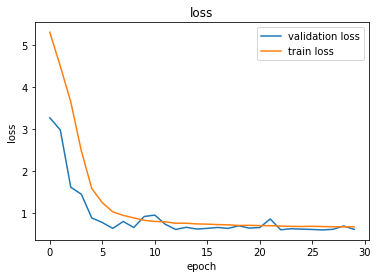

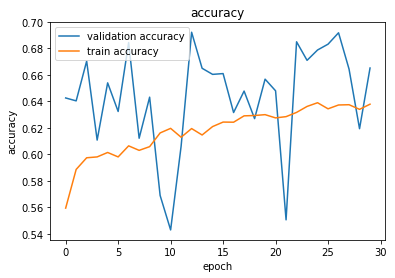

In [31]:
show_loss(hist)
show_acc(hist)

In [37]:
lr_base = 0.00008

hist = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_split=0.2, callbacks=[scheduler])

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
Epoch 0 , new lr==0.000080
20000/20000 [==============================] - 2s 115us/step - loss: 0.6555 - acc: 0.6444 - val_loss: 0.5891 - val_acc: 0.6910
Epoch 2/10
Epoch 1 , new lr==0.000080
20000/20000 [==============================] - 2s 117us/step - loss: 0.6560 - acc: 0.6429 - val_loss: 0.5963 - val_acc: 0.6806
Epoch 3/10
Epoch 2 , new lr==0.000075
20000/20000 [==============================] - 2s 114us/step - loss: 0.6494 - acc: 0.6433 - val_loss: 0.6262 - val_acc: 0.6608
Epoch 4/10
Epoch 3 , new lr==0.000075
20000/20000 [==============================] - 2s 116us/step - loss: 0.6535 - acc: 0.6428 - val_loss: 0.6630 - val_acc: 0.6134
Epoch 5/10
Epoch 4 , new lr==0.000071
20000/20000 [==============================] - 2s 114us/step - loss: 0.6469 - acc: 0.6436 - val_loss: 0.6367 - val_acc: 0.6458
Epoch 6/10
Epoch 5 , new lr==0.000071
20000/20000 [==============================] - 2s 117us/step - loss: 0.6490 - acc: 0.644

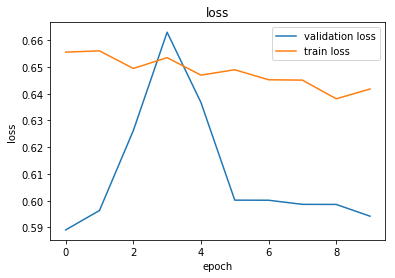

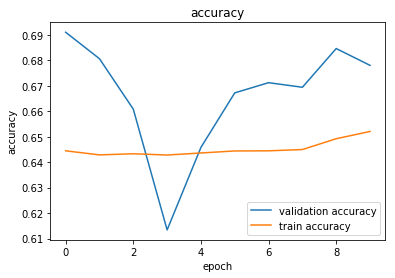

In [38]:
show_loss(hist)
show_acc(hist)

按照论文的推荐的训练方式，我尝试了很多方法，但是效果都不好。并且现在验证集非常不稳定。所以我打算采用另一种算法来训练。首先尝试Adam。

In [17]:
from keras.optimizers import Adam

## setup model
input_tensor = Input(shape=(2048,))
#x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid', name='res_dense_1')(input_tensor)

model = Model(inputs=input_tensor, outputs=x)

##compile
#opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

##fit
hist = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/100
20000/20000 [==============================] - 5s 232us/step - loss: 0.0538 - acc: 0.9881 - val_loss: 0.0247 - val_acc: 0.9910
Epoch 2/100
20000/20000 [==============================] - 2s 125us/step - loss: 0.0206 - acc: 0.9942 - val_loss: 0.0211 - val_acc: 0.9918
Epoch 3/100
20000/20000 [==============================] - 2s 124us/step - loss: 0.0170 - acc: 0.9954 - val_loss: 0.0208 - val_acc: 0.9926
Epoch 4/100
20000/20000 [==============================] - 2s 124us/step - loss: 0.0158 - acc: 0.9953 - val_loss: 0.0209 - val_acc: 0.9926
Epoch 5/100
20000/20000 [==============================] - 2s 125us/step - loss: 0.0145 - acc: 0.9950 - val_loss: 0.0250 - val_acc: 0.9918
Epoch 6/100
20000/20000 [==============================] - 3s 125us/step - loss: 0.0130 - acc: 0.9958 - val_loss: 0.0239 - val_acc: 0.9918
Epoch 7/100
20000/20000 [==============================] - 3s 130us/step - loss: 0.0117 - acc: 0.9963 - val_loss: 0.0

KeyboardInterrupt: 

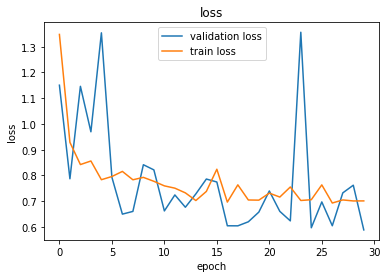

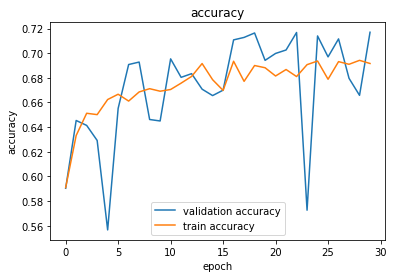

In [41]:
show_loss(hist)
show_acc(hist)

从上图可以看出，loss在下降，accuracy在上升，但是都震荡得比较厉害，说明我们的学习速率太高了。那么现在我们来降低学习速率。

In [51]:
from keras.optimizers import Adam

##compile
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.000001, amsgrad=False)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

##fit
hist = model.fit(x_train, y_train, batch_size=32, epochs=30, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 4s 180us/step - loss: 0.5319 - acc: 0.7390 - val_loss: 0.6543 - val_acc: 0.6864
Epoch 2/30
20000/20000 [==============================] - 2s 120us/step - loss: 0.5308 - acc: 0.7399 - val_loss: 0.5744 - val_acc: 0.7178
Epoch 3/30
20000/20000 [==============================] - 2s 120us/step - loss: 0.5233 - acc: 0.7462 - val_loss: 0.6089 - val_acc: 0.7040
Epoch 4/30
20000/20000 [==============================] - 2s 121us/step - loss: 0.5228 - acc: 0.7419 - val_loss: 0.6145 - val_acc: 0.7116
Epoch 5/30
20000/20000 [==============================] - 2s 120us/step - loss: 0.5275 - acc: 0.7409 - val_loss: 0.5956 - val_acc: 0.7126
Epoch 6/30
20000/20000 [==============================] - 2s 120us/step - loss: 0.5246 - acc: 0.7416 - val_loss: 0.5659 - val_acc: 0.7266
Epoch 7/30
20000/20000 [==============================] - 2s 120us/step - loss: 0.5230 - acc: 0.7379 - val_loss: 0.5908 - v

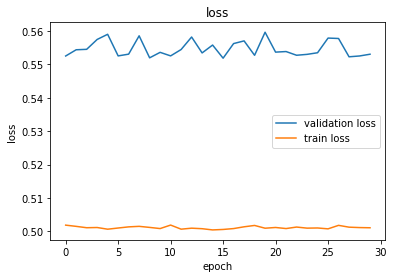

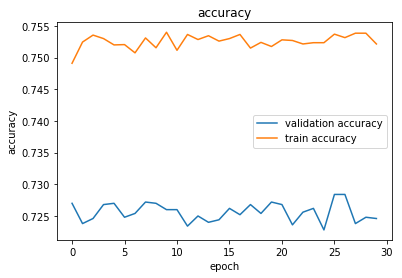

In [49]:
show_loss(hist)
show_acc(hist)

调试了很久，也无法将基本的accuracy提升上来。我想现在这种情况应该先想办法把训练集的accuracy增加上来再说，然后再考虑过拟合等问题，所以我会再加上一个全连接层。

In [11]:
## setup model
input_tensor = Input(shape=(2048,))
x = Dropout(0.5)(input_tensor)
x = Dense(1024, activation='relu', name='res_dense_1')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid', name='res_dense_2')(x)


model = Model(inputs=input_tensor, outputs=x)

##compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

##fit
hist = model.fit(x_train, y_train, batch_size=32, epochs=30, validation_split=0.2)

NameError: name 'x_train' is not defined